In [3]:
from gurobipy import Model, GRB, quicksum
import random
import itertools

# Definir el tamaño del intervalo en minutos
intervalo_minutos = 15  # Ajusté a 15 minutos para mayor granularidad

# Total de intervalos desde las 5 am hasta las 9 pm
horas_operacion = 16  # Desde las 5 am hasta las 21 pm
total_intervalos = horas_operacion * (60 // intervalo_minutos)

# Crear la lista de intervalos de tiempo
T = range(1, total_intervalos + 1)  # t = 1, 2, ..., total_intervalos

# Número de buses
num_buses =5

# Crear la lista de buses
B = range(1, num_buses + 1)  # b = 1, 2, ..., num_buses

# Número de estaciones
num_estaciones = 2  # Ajustado a 2 estaciones para simplificar

# Crear los conjuntos de orígenes y destinos
O = range(1, num_estaciones + 1)
D = range(1, num_estaciones + 1)

# Definir tau (tiempos de viaje) entre estaciones
tau = {}
for o, d in itertools.product(O, D):
    if o != d:
        tau[o, d] = 3  # Tiempo de viaje fijo para simplificar

# Capacidad de los buses
C = 50  # Puedes ajustar este valor o definir capacidades diferentes para cada bus

# Definir el porcentaje mínimo de ocupación (por ejemplo, 50%)
FactorMinimo = 0.5

# Demanda mínima requerida para enviar un bus
demanda_minima = int(FactorMinimo * C)  # 25 pasajeros si C = 50 y FactorMinimo = 0.5

# Generar demandas variables para cada intervalo de tiempo y sentido
D_demanda = {}
for t in T:
    for o, d in itertools.product(O, D):
        if o != d:
            if (t in range(9, 17)) or (t in range(33, 41)):
                # Horas pico: mayor demanda
                demanda = random.randint(max(80, demanda_minima), 150)
            else:
                # Horas valle: demanda mínima
                demanda = random.randint(demanda_minima, 60)
            D_demanda[t, o, d] = demanda

# Crear el modelo
m = Model("Despacho_de_Buses_Con_Ocupacion_Minima")

# Variables de decisión x_{t}^{od,b}
x = m.addVars(((t, o, d, b)
               for t in T
               for o, d in itertools.product(O, D)
               for b in B
               if o != d),
              vtype=GRB.BINARY, name="x")

# Variables de ubicación L_{t}^{b,o}
L = m.addVars(T, B, O, vtype=GRB.BINARY, name="L")

# Variables de pasajeros P_{t}^{od,b}
P = m.addVars(((t, o, d, b)
               for t in T
               for o, d in itertools.product(O, D)
               for b in B
               if o != d),
              vtype=GRB.CONTINUOUS, name="P")

# Función objetivo: Maximizar el número total de pasajeros transportados
m.setObjective(quicksum(P.values()), GRB.MAXIMIZE)

# Restricción (1): P_{t}^{od,b} <= C * x_{t}^{od,b}
m.addConstrs((P[t, o, d, b] <= C * x[t, o, d, b]
              for t in T
              for o, d in itertools.product(O, D)
              for b in B
              if o != d), name="Capacidad_Salida")

# *Restricción para evitar enviar buses con menos del mínimo de ocupación*
m.addConstrs((P[t, o, d, b] >= FactorMinimo * C * x[t, o, d, b]
              for t in T
              for o, d in itertools.product(O, D)
              for b in B
              if o != d), name="Ocupacion_Minima")

# Restricción (2): Sum_b P_{t}^{od,b} <= D_t^{od}
m.addConstrs((quicksum(P[t, o, d, b] for b in B) <= D_demanda[t, o, d]
              for t in T
              for o, d in itertools.product(O, D)
              if o != d), name="Demanda")

# Inicialización de L para t = 1
for b in B:
    for o in O:
        if o == 1:
            m.addConstr(L[1, b, o] == 1, name=f"L_init_{b}_{o}")
        else:
            m.addConstr(L[1, b, o] == 0, name=f"L_init_{b}_{o}")

# Actualización de L para t > 1
for b in B:
    for t in T:
        if t > 1:
            for o in O:
                salida = quicksum(x[t - 1, o, d, b] for d in D if o != d and (t - 1) in T)
                llegada = quicksum(x[t - tau[d, o], d, o, b]
                                   for d in D if o != d and (t - tau[d, o]) >= 1)
                m.addConstr(L[t, b, o] == L[t - 1, b, o] - salida + llegada,
                            name=f"L_update_{t}{b}{o}")

# Un bus solo puede salir desde donde se encuentra
for b in B:
    for t in T:
        for o in O:
            for d in D:
                if o != d:
                    m.addConstr(x[t, o, d, b] <= L[t, b, o], name=f"Salida_Loc_{t}{b}{o}_{d}")

# Resolver el modelo
m.optimize()

# Verificar el estado de optimización
if m.status == GRB.OPTIMAL:
    print("\nSolución Óptima Encontrada:\n")

    # Mostrar el número total de pasajeros transportados
    print(f"Total de pasajeros transportados: {m.objVal}\n")

    # Mostrar la asignación de buses y pasajeros
    for b in B:
        print(f"Bus {b}:")
        for t in T:
            for o, d in itertools.product(O, D):
                if o != d and x.get((t, o, d, b)) and x[t, o, d, b].x > 0.5:
                    pasajeros = P[t, o, d, b].x
                    print(f"  Tiempo {t}: Sale de {o} a {d} con {pasajeros} pasajeros")
        print()
else:
    print("No se encontró una solución óptima.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2688 rows, 1920 columns and 6990 nonzeros
Model fingerprint: 0xc831caea
Variable types: 640 continuous, 1280 integer (1280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 153 rows and 95 columns
Presolve time: 0.02s
Presolved: 2535 rows, 1825 columns, 6645 nonzeros
Variable types: 0 continuous, 1825 integer (1215 binary)
Found heuristic solution: objective 25.0000000
Found heuristic solution: objective 61.0000000

Root relaxation: objective 4.510720e+03, 4265 iterations, 0.30 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

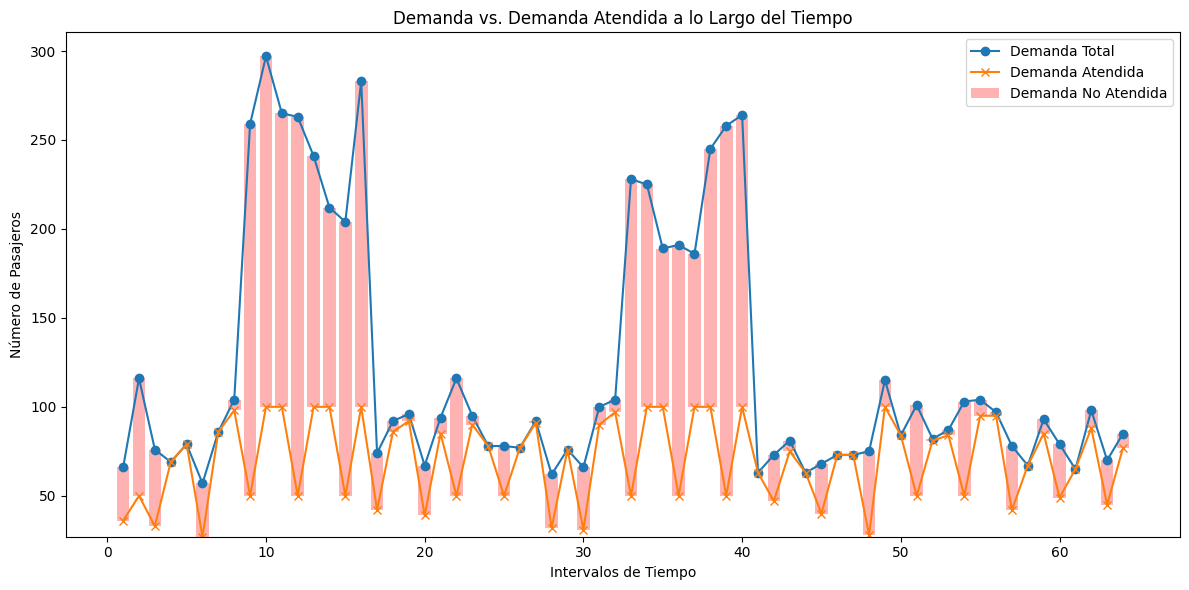

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Preparar datos
intervalos_tiempo = sorted(T)
demanda_total = [sum(D_demanda[t, o, d] for o in O for d in D if o != d) for t in intervalos_tiempo]
atendidos_total = [sum(P[t, o, d, b].x for o in O for d in D for b in B if o != d) for t in intervalos_tiempo]
demanda_no_atendida = [d - s for d, s in zip(demanda_total, atendidos_total)]

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(intervalos_tiempo, demanda_total, label='Demanda Total', marker='o')
plt.plot(intervalos_tiempo, atendidos_total, label='Demanda Atendida', marker='x')
plt.bar(intervalos_tiempo, demanda_no_atendida, bottom=atendidos_total, color='red', alpha=0.3, label='Demanda No Atendida')
plt.xlabel('Intervalos de Tiempo')
plt.ylabel('Número de Pasajeros')
plt.title('Demanda vs. Demanda Atendida a lo Largo del Tiempo')
plt.legend()
plt.tight_layout()
plt.show()


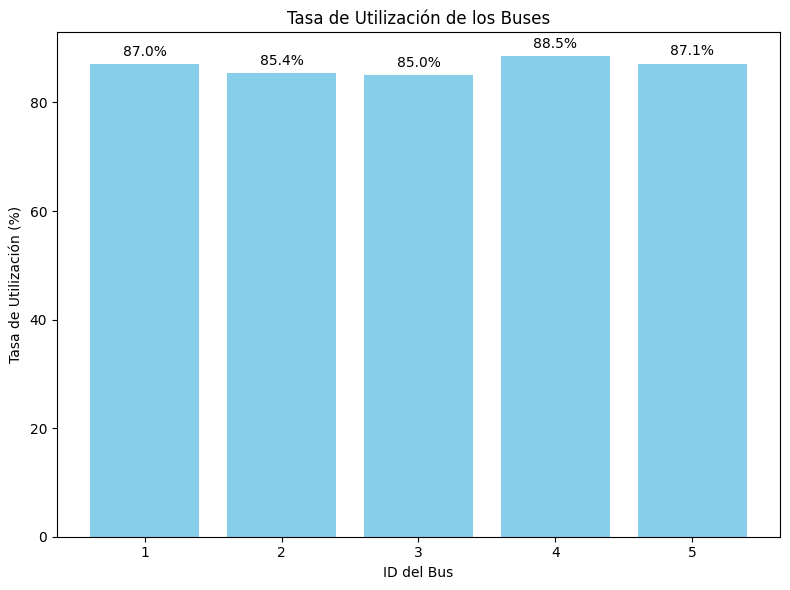

In [15]:
import numpy as np

utilizacion_buses = {}
for b in B:
    pasajeros_total = sum(P[t, o, d, b].x for t in T for o in O for d in D if o != d)
    viajes_total = sum(x[t, o, d, b].x for t in T for o in O for d in D if o != d)
    capacidad_total = viajes_total * C
    tasa_utilizacion = (pasajeros_total / capacidad_total) * 100 if capacidad_total > 0 else 0
    utilizacion_buses[b] = tasa_utilizacion

# Graficar
plt.figure(figsize=(8, 6))
barras = plt.bar(utilizacion_buses.keys(), utilizacion_buses.values(), color='skyblue')
plt.xlabel('ID del Bus')
plt.ylabel('Tasa de Utilización (%)')
plt.title('Tasa de Utilización de los Buses')
plt.xticks(list(B))

# Agregar porcentajes encima de las barras
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\57313\AppData\Local\Temp\ipykernel_27156\1271398496.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores = plt.cm.get_cmap('tab20', len(trayectos))


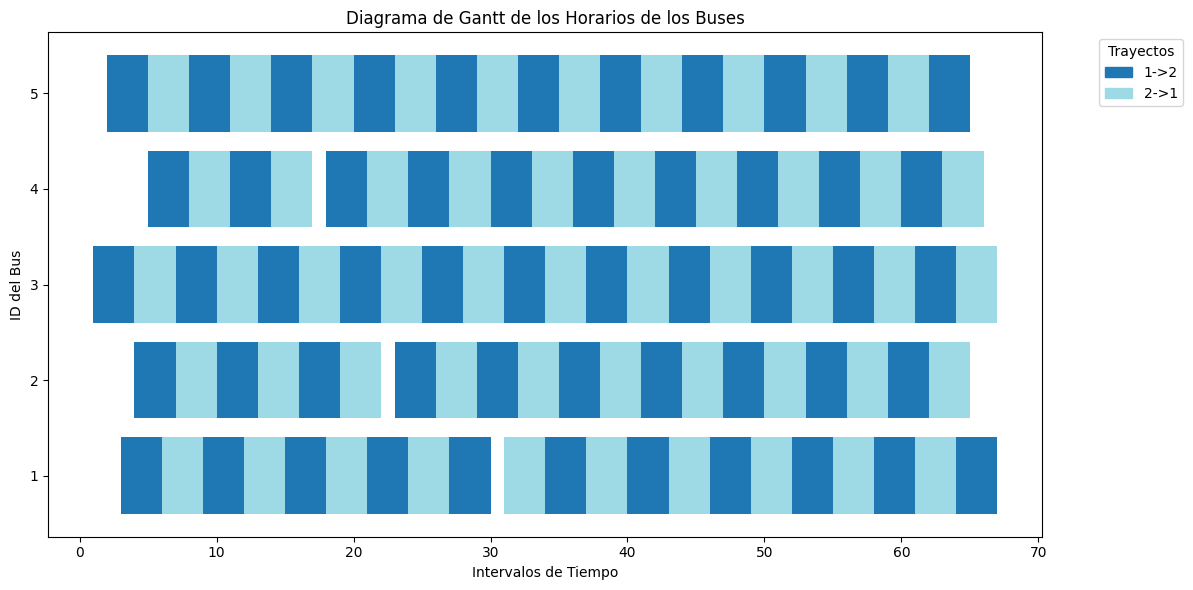

In [16]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Colores para los trayectos
trayecto_colores = {}
trayectos = list(set((o, d) for o, d in itertools.product(O, D) if o != d))
colores = plt.cm.get_cmap('tab20', len(trayectos))
for idx, (o, d) in enumerate(trayectos):
    trayecto_colores[(o, d)] = colores(idx)

for b in B:
    for t in T:
        for o, d in itertools.product(O, D):
            if o != d and x.get((t, o, d, b)) and x[t, o, d, b].x > 0.5:
                duracion = tau[o, d]  # Duración del viaje
                ax.broken_barh([(t, duracion)], (b - 0.4, 0.8), facecolors=trayecto_colores[(o, d)])

# Configurar el gráfico
ax.set_xlabel('Intervalos de Tiempo')
ax.set_ylabel('ID del Bus')
ax.set_yticks(list(B))
ax.set_title('Diagrama de Gantt de los Horarios de los Buses')

# Crear leyenda para los trayectos
handles = [mpatches.Patch(color=trayecto_colores[(o, d)], label=f'{o}->{d}') for o, d in trayectos]
ax.legend(handles=handles, title='Trayectos', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


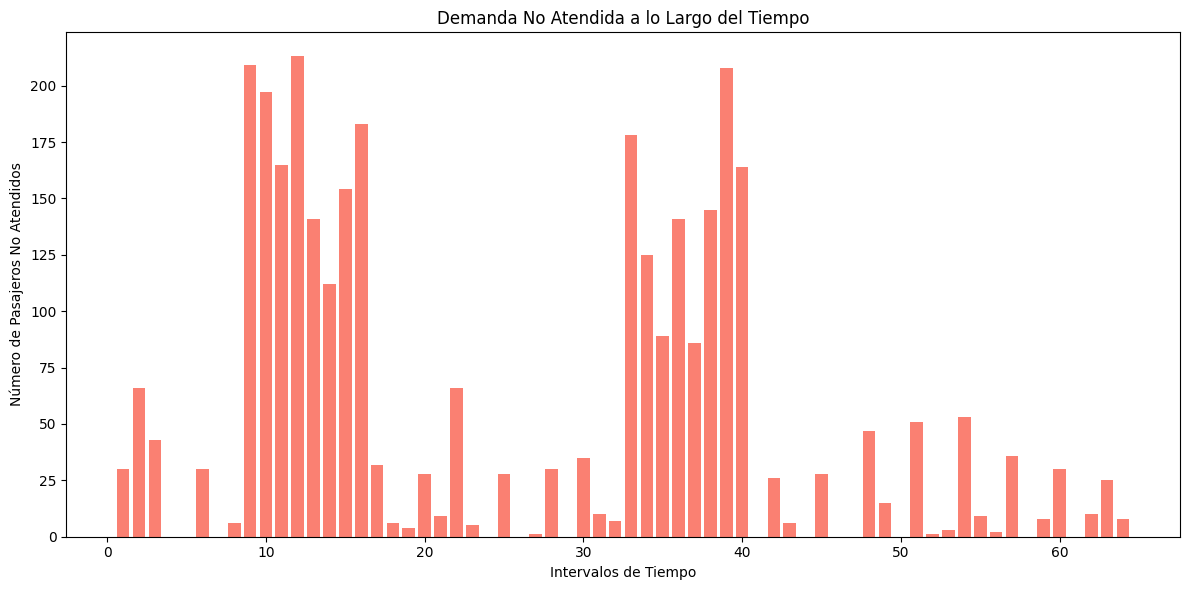

In [18]:
# Graficar
plt.figure(figsize=(12, 6))
plt.bar(intervalos_tiempo, demanda_no_atendida, color='salmon')
plt.xlabel('Intervalos de Tiempo')
plt.ylabel('Número de Pasajeros No Atendidos')
plt.title('Demanda No Atendida a lo Largo del Tiempo')
plt.tight_layout()
plt.show()


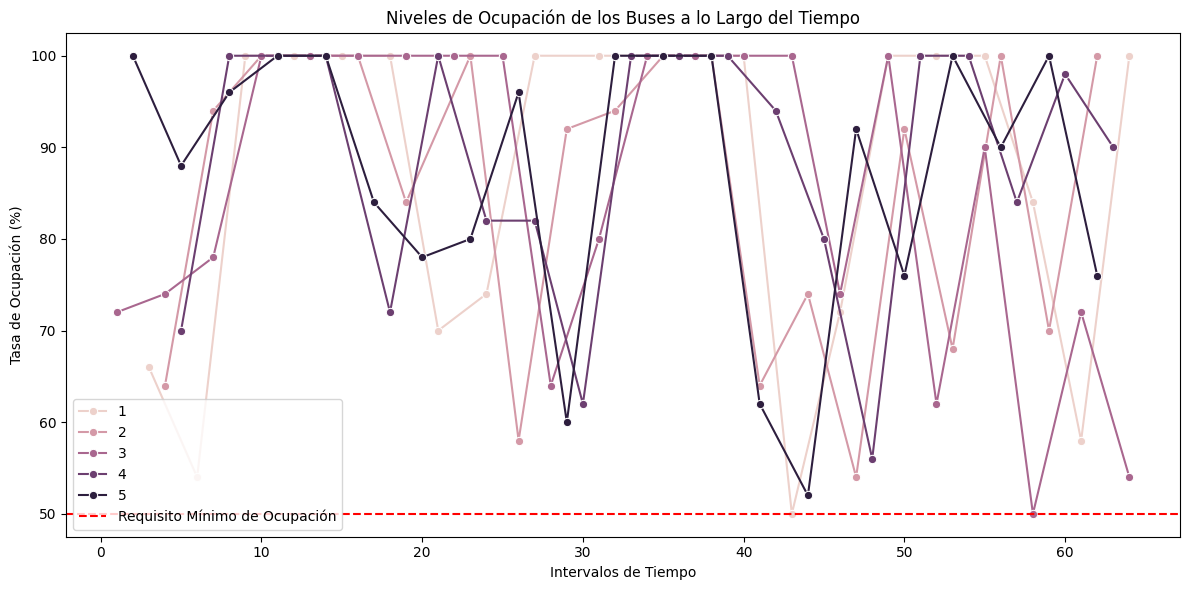

In [19]:
import seaborn as sns

ocupacion_datos = []
for b in B:
    for t in T:
        for o, d in itertools.product(O, D):
            if o != d and x.get((t, o, d, b)) and x[t, o, d, b].x > 0.5:
                pasajeros = P[t, o, d, b].x
                tasa_ocupacion = (pasajeros / C) * 100
                ocupacion_datos.append([t, b, tasa_ocupacion])

df_ocupacion = pd.DataFrame(ocupacion_datos, columns=['Tiempo', 'Bus', 'Tasa_Ocupacion'])

# Graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_ocupacion, x='Tiempo', y='Tasa_Ocupacion', hue='Bus', marker='o')
plt.axhline(y=FactorMinimo * 100, color='red', linestyle='--', label='Requisito Mínimo de Ocupación')
plt.xlabel('Intervalos de Tiempo')
plt.ylabel('Tasa de Ocupación (%)')
plt.title('Niveles de Ocupación de los Buses a lo Largo del Tiempo')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import plotly.graph_objects as go

# Preparar datos
origen_destino = {}
for o, d in itertools.product(O, D):
    if o != d:
        pasajeros_total = sum(P[t, o, d, b].x for t in T for b in B)
        origen_destino[(o, d)] = pasajeros_total

# Crear listas para el diagrama
sources = []
targets = []
values = []
labels = [f'Estación {o}' for o in O]

for (o, d), pasajeros in origen_destino.items():
    sources.append(o - 1)
    targets.append(d - 1)
    values.append(pasajeros)

# Crear el diagrama Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    ))])

fig.update_layout(title_text="Flujo de Pasajeros entre Estaciones", font_size=10)
fig.show()


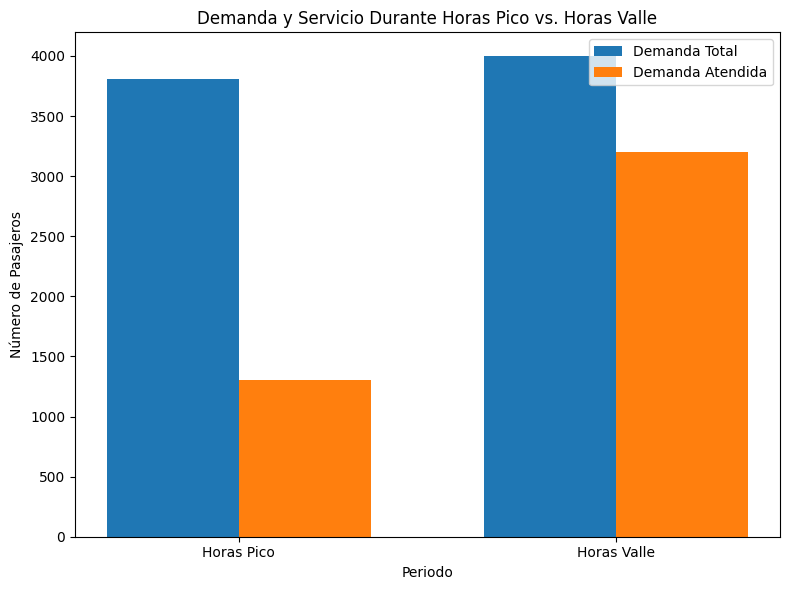

In [21]:
peak_hours = list(range(9, 17)) + list(range(33, 41))
off_peak_hours = [t for t in T if t not in peak_hours]

def aggregate_demand(time_list):
    demanda_total = sum(D_demanda[t, o, d] for t in time_list for o in O for d in D if o != d)
    atendidos_total = sum(P[t, o, d, b].x for t in time_list for o in O for d in D for b in B if o != d)
    return demanda_total, atendidos_total

demanda_pico, atendidos_pico = aggregate_demand(peak_hours)
demanda_valle, atendidos_valle = aggregate_demand(off_peak_hours)

# Graficar
etiquetas = ['Horas Pico', 'Horas Valle']
valores_demanda = [demanda_pico, demanda_valle]
valores_atendidos = [atendidos_pico, atendidos_valle]

x = np.arange(len(etiquetas))
ancho = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - ancho/2, valores_demanda, ancho, label='Demanda Total')
plt.bar(x + ancho/2, valores_atendidos, ancho, label='Demanda Atendida')
plt.xlabel('Periodo')
plt.ylabel('Número de Pasajeros')
plt.title('Demanda y Servicio Durante Horas Pico vs. Horas Valle')
plt.xticks(x, etiquetas)
plt.legend()
plt.tight_layout()
plt.show()
